In [1]:
import git
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data from compare-models notebook
episodes = pd.read_pickle("episodes.pkl")
episodes = episodes.assign(family=episodes.protocol)


def protocol(row):
    if row.family == "nakamoto":
        return "nakamoto"
    elif row.family == "bk":
        return f"bk-{row.k}"
    elif row.family == "tailstorm":
        return f"tailstorm-{row.k}-{row.reward}"
    else:
        assert false


episodes = episodes.assign(protocol=episodes.apply(protocol, axis=1))
episodes = episodes.assign(
    protocol=pd.Categorical(
        episodes.protocol,
        categories=sorted(set(episodes.protocol), key=lambda x: x != "nakamoto"),
    )
)
episodes = episodes.assign(
    kind=pd.Categorical(episodes.kind, categories=["trained", "hard-coded"])
)
columns = list(episodes.columns)
columns.remove("family")
columns.insert(1, "family")
episodes = episodes[columns]
episodes = episodes.assign(
    episode_relrew=lambda d: d.episode_reward_attacker
    / (d.episode_reward_attacker + d.episode_reward_defender),
    episode_rpp=lambda d: d.episode_reward_attacker / d.episode_progress,
)
list(episodes.columns)

['protocol',
 'family',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'ent_coef',
 'shape',
 'policy',
 'path',
 'kind',
 'reuse',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations',
 'episode_relrew',
 'episode_rpp']

In [3]:
dict(
    alpha=episodes.alpha.drop_duplicates().sort_values().tolist(),
    gamma=episodes.gamma.drop_duplicates().sort_values().tolist(),
    kind=episodes.kind.drop_duplicates().sort_values().tolist(),
    reuse=episodes.reuse.drop_duplicates().sort_values().tolist(),
    n_episodes=len(episodes.episode.drop_duplicates()),
    n_models=len(episodes.path.drop_duplicates()) - 1,  # minus 1 for NaN
)

{'alpha': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
 'gamma': [0.05, 0.5, 0.95],
 'kind': ['trained', 'hard-coded'],
 'reuse': ['-', 'gamma05', 'gamma50', 'gamma95', 'proto'],
 'n_episodes': 100,
 'n_models': 933}

In [4]:
setting_key = ["protocol", "family", "k", "subblock_selection", "alpha", "gamma"]
settings = (
    episodes[setting_key]
    .drop_duplicates()
    .sort_values(setting_key)
    .reset_index(drop=True)
)
settings

,protocol,family,k,subblock_selection,alpha,gamma
0,nakamoto,nakamoto,1,n/a,0.20,0.05
1,nakamoto,nakamoto,1,n/a,0.20,0.50
2,nakamoto,nakamoto,1,n/a,0.20,0.95
3,nakamoto,nakamoto,1,n/a,0.25,0.05
4,nakamoto,nakamoto,1,n/a,0.25,0.50
...,...,...,...,...,...,...
79,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.50
80,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.95
81,tailstorm-8-discount,tailstorm,8,heuristic,0.50,0.05
82,tailstorm-8-discount,tailstorm,8,heuristic,0.50,0.50


In [5]:
trained_episodes = (
    episodes.query('kind == "trained" or (family in ["nakamoto", "tailstorm"])')
    .sort_values(setting_key)
    .reset_index(drop=True)
)
trained_episodes[setting_key + ["policy"]]

,protocol,family,k,subblock_selection,alpha,gamma,policy
0,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-ogyc40rm_2
1,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-k9f921f4_2
2,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-rh4janrq_2
3,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-rh4janrq-best
4,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-e4t5565f-best
...,...,...,...,...,...,...,...
330195,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,ppo-md0x6pei_2
330196,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,avoid-loss
330197,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,minor-delay
330198,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,get-ahead


In [6]:
model_key = setting_key + ["policy", "kind"]
models = (
    trained_episodes.groupby(model_key, observed=True)
    .agg(
        n=("episode", len),
        relrew_mean=("episode_relrew", np.mean),
        relrew_std=("episode_relrew", np.std),
        rpp_mean=("episode_rpp", np.mean),
        rpp_std=("episode_rpp", np.std),
    )
    .reset_index()
)
models

,protocol,family,k,subblock_selection,alpha,gamma,policy,kind,n,relrew_mean,relrew_std,rpp_mean,rpp_std
0,nakamoto,nakamoto,1,n/a,0.2,0.05,eyal-sirer-2014,hard-coded,100,0.134661,0.012687,0.134661,0.012687
1,nakamoto,nakamoto,1,n/a,0.2,0.05,honest,hard-coded,100,0.200741,0.008554,0.200741,0.008554
2,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-574o3o0x-best,trained,100,0.199887,0.008065,0.199887,0.008065
3,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-574o3o0x_2,trained,100,0.198138,0.008170,0.198138,0.008170
4,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-9ig2f1jz-best,trained,100,0.202019,0.009282,0.202019,0.009282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3297,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,ppo-trc2qwty_2,trained,100,0.428034,0.345663,0.426858,0.344939
3298,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,ppo-wndmtutv-best,trained,100,0.773773,0.171476,0.739040,0.174904
3299,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,ppo-wndmtutv_2,trained,100,0.632712,0.298497,0.628317,0.297355
3300,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,ppo-yq5cyv5x-best,trained,100,0.250642,0.043402,0.228720,0.038997


In [7]:
best_models = models.loc[
    models.groupby(setting_key + ["kind"], observed=True).rpp_mean.idxmax()
]
best_models_episodes = pd.merge(
    best_models[model_key], episodes, on=model_key, how="left"
)

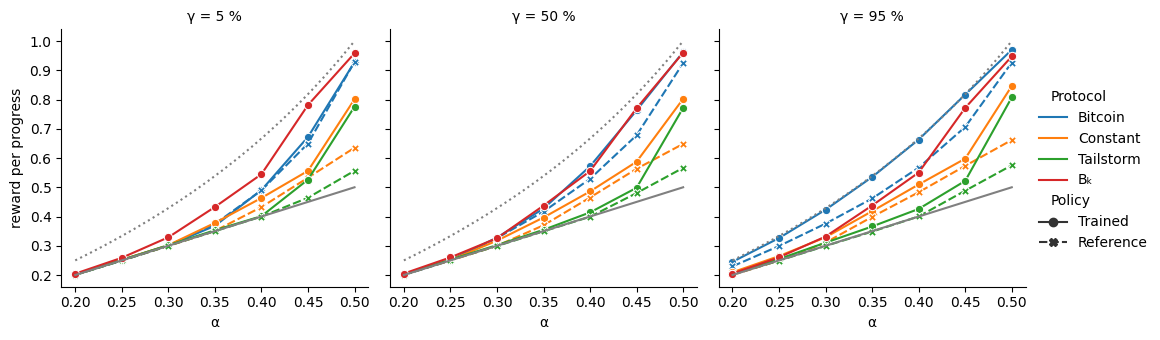

In [8]:
# Some renaming for the paper
def humProtocol(x):
    if x == "nakamoto":
        return "Bitcoin"
    if x == "tailstorm-8-discount":
        return "Tailstorm"
    if x == "tailstorm-8-constant":
        return "Constant"
    if x == "bk-8":
        return "Bₖ"
    return x


def humPolicy(x):
    if x == "trained":
        return "Trained"
    if x == "hard-coded":
        return "Reference"
    return x


subset = best_models
subset["Protocol"] = subset.protocol.map(humProtocol)
subset.Protocol = pd.Categorical(
    subset.Protocol, categories=["Bitcoin", "Constant", "Tailstorm", "Bₖ"]
)
subset["Policy"] = subset.kind.map(humPolicy)
subset.Policy = pd.Categorical(subset.Policy, categories=["Trained", "Reference"])
subset["γ"] = subset.gamma.map(lambda x: f"{x * 100:g} %")
subset["α"] = subset.alpha

fig = sns.relplot(
    kind="line",
    data=subset,
    y="rpp_mean",
    x="α",
    col="γ",
    hue="Protocol",
    style="Policy",
    markers=True,
    height=3.5,
    aspect=1,
)
fig.set(ylabel="reward per progress", xlabel="α")
for ax in fig.axes.flatten():
    alpha = np.linspace(min(best_models.alpha), max(best_models.alpha), 20)
    ax.plot(alpha, alpha, linestyle="solid", color="gray")
    ax.plot(alpha, alpha / (1 - alpha), linestyle="dotted", color="gray")


fig.savefig(
    "reward_per_progress_rl.png",
    dpi=600,
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)